In [1]:
import numpy as np
import pandas as pd
import sklearn as sk
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler,OneHotEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, f1_score
from sklearn.metrics import recall_score, precision_recall_fscore_support,classification_report
from sklearn.model_selection import train_test_split
import seaborn as sns
from imblearn.pipeline import Pipeline as IMBPipeline
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


# Question 1: Segmentation, Assignment Generation, and Churn Prediction Using Merchant Transaction Activity

In [2]:
# Read in the file
df1 = pd.read_csv('homework7_file1.csv')
df1.head()

,merchant,time,amount_usd_in_cents
0,d087d4c321,2034-12-11 22:16:41,5059
1,fe1cb2e840,2034-08-13 21:11:59,12743
2,878047f4b9,2033-06-05 21:15:00,7601
3,3932608d23,2034-04-28 19:55:01,5790
4,84a09b4188,2034-07-26 04:37:05,6153


## Task 1 - Feature Generation

In [3]:
## CREDIT TO PROFESSOR, AS I AM USING SAME TECHNIQUE TO GROUP IN LISTS

#transform to datetime format
df1['time'] = df1['time'].apply(pd.to_datetime)

#sort time, group by merchant, and aggregate into a list
df1 = df1.sort_values(by='time')
df1_grouped = df1.groupby('merchant').agg(list).reset_index()

df1_grouped.head()

,merchant,time,amount_usd_in_cents
0,00057d4302,"[2033-05-30 02:54:34, 2033-05-30 04:20:31]","[1156, 1279]"
1,000ed1585f,"[2033-05-08 15:51:43, 2033-05-19 13:15:51, 203...","[32004, 35784, 21932, 22481]"
2,000f8c3297,"[2033-12-20 17:57:20, 2034-01-26 15:10:54, 203...","[7374, 14489, 15047, 4623, 3826, 3643, 4155, 7..."
3,0020aefbd9,[2034-05-30 21:55:06],[3589]
4,0026f256ac,[2033-09-15 01:17:32],[34880]


In [4]:
# Creating the new features

# Adding the minimum transaction amount for each merchant
df1_grouped['trans_amount_min'] = df1_grouped['amount_usd_in_cents'].apply(min)

# Adding the maximum transaction amount for each merchant
df1_grouped['trans_amount_max'] = df1_grouped['amount_usd_in_cents'].apply(max)

# Adding the average transaction amount for each merchant
df1_grouped['trans_amount_avg'] = df1_grouped['amount_usd_in_cents'].apply(lambda x: sum(x) / len(x))

# Adding the total transaction amount for each merchant (volume)
df1_grouped['trans_amount_volume'] = df1_grouped['amount_usd_in_cents'].apply(sum)

# Adding the transaction frequency for each merchant
df1_grouped['trans_frequency'] = df1_grouped['amount_usd_in_cents'].apply(len)


reference_date = pd.to_datetime('2035-01-01')

# Calculating recency of the last transaction
df1_grouped['trans_recency'] = df1_grouped['time'].apply(lambda x: (reference_date - max(x)).days)

# Calculating average time between transactions in hours
def calculate_avg_time_between_trans(times_list):
    if len(times_list) <= 1:
        return 0
    else:
        # Calculate differences between consecutive transactions, convert to hours and average
        diffs = [times_list[i] - times_list[i-1] for i in range(1, len(times_list))]
        avg_diff = sum(diffs, pd.Timedelta(0)) / len(diffs)
        return avg_diff.total_seconds() / 3600  # Convert seconds to hours

df1_grouped['avg_time_btwn_trans'] = df1_grouped['time'].apply(calculate_avg_time_between_trans)


#Calculating average growth rate in transaction amounts
def calculate_avg_growth_rate(amounts_list):
    if len(amounts_list) <= 1:
        return 0
    else:
        # Calculate percentage change between consecutive transactions and average
        growth_rates = [(amounts_list[i] - amounts_list[i-1]) / amounts_list[i-1] for i in range(1, len(amounts_list))]
        avg_growth_rate = sum(growth_rates) / len(growth_rates) *100
        return avg_growth_rate

df1_grouped['avg_trans_growth_rate'] = df1_grouped['amount_usd_in_cents'].apply(calculate_avg_growth_rate)

# Let's see the data
df1_grouped.head()

,merchant,time,amount_usd_in_cents,trans_amount_min,trans_amount_max,trans_amount_avg,trans_amount_volume,trans_frequency,trans_recency,avg_time_btwn_trans,avg_trans_growth_rate
0,00057d4302,"[2033-05-30 02:54:34, 2033-05-30 04:20:31]","[1156, 1279]",1156,1279,1217.5000,2435,2,580,1.432500,10.640138
1,000ed1585f,"[2033-05-08 15:51:43, 2033-05-19 13:15:51, 203...","[32004, 35784, 21932, 22481]",21932,35784,28050.2500,112201,4,174,3424.033796,-8.131941
2,000f8c3297,"[2033-12-20 17:57:20, 2034-01-26 15:10:54, 203...","[7374, 14489, 15047, 4623, 3826, 3643, 4155, 7...",3455,15047,6635.5625,106169,16,58,508.465889,22.675141
3,0020aefbd9,[2034-05-30 21:55:06],[3589],3589,3589,3589.0000,3589,1,215,0.000000,0.000000
4,0026f256ac,[2033-09-15 01:17:32],[34880],34880,34880,34880.0000,34880,1,472,0.000000,0.000000


In [5]:
# let's drop the columns with the lists as we don't need them anymore
df1_grouped.drop(columns=['time', 'amount_usd_in_cents'], inplace=True)
df1_grouped.head()

,merchant,trans_amount_min,trans_amount_max,trans_amount_avg,trans_amount_volume,trans_frequency,trans_recency,avg_time_btwn_trans,avg_trans_growth_rate
0,00057d4302,1156,1279,1217.5000,2435,2,580,1.432500,10.640138
1,000ed1585f,21932,35784,28050.2500,112201,4,174,3424.033796,-8.131941
2,000f8c3297,3455,15047,6635.5625,106169,16,58,508.465889,22.675141
3,0020aefbd9,3589,3589,3589.0000,3589,1,215,0.000000,0.000000
4,0026f256ac,34880,34880,34880.0000,34880,1,472,0.000000,0.000000


## Task 2: Merchant Segmentation

### Optimal Number of Clusters with the Elbow Method

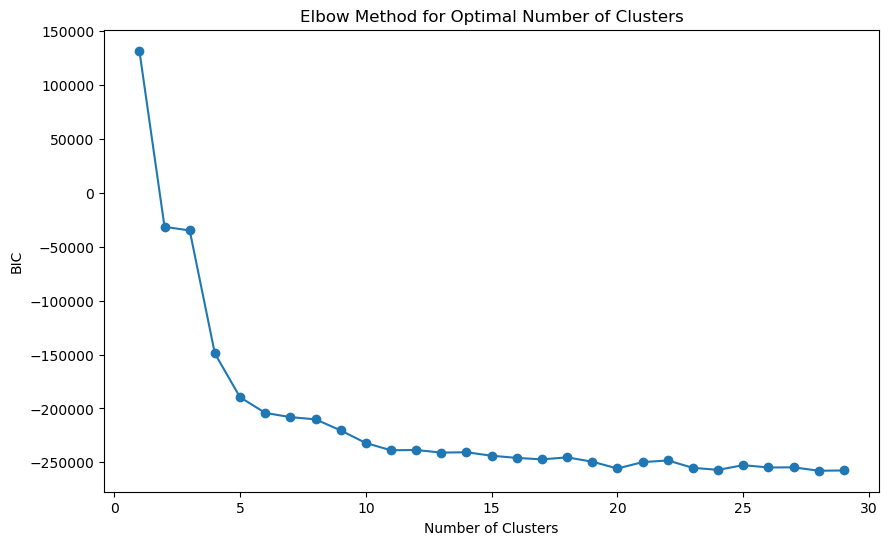

In [6]:
# Select the relevant features for clustering
features = df1_grouped[['trans_amount_min', 'trans_amount_max', 'trans_amount_avg', 'trans_amount_volume',
                        'trans_frequency','trans_recency','avg_time_btwn_trans','avg_trans_growth_rate']]

# Let's scale all features
features_scaled = StandardScaler().fit_transform(features)

# Determine the optimal number of clusters using the elbow method. The metric we'll use is BIC (Bayesian Information Criterion)
n_clusters = range(1, 30)
bics = []

for n in n_clusters:
    gmm = GaussianMixture(n_components=n, random_state=0).fit(features_scaled)
    bics.append(gmm.bic(features_scaled))

plt.figure(figsize=(10, 6))
plt.plot(n_clusters, bics, marker='o')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('BIC')
plt.show()


In [7]:
#### By looking at the plot it seems 6 is the elbow of the plot

In [8]:
optimal_n = 6

### Dimensionality Reduction with PCA and Clustering Visualization

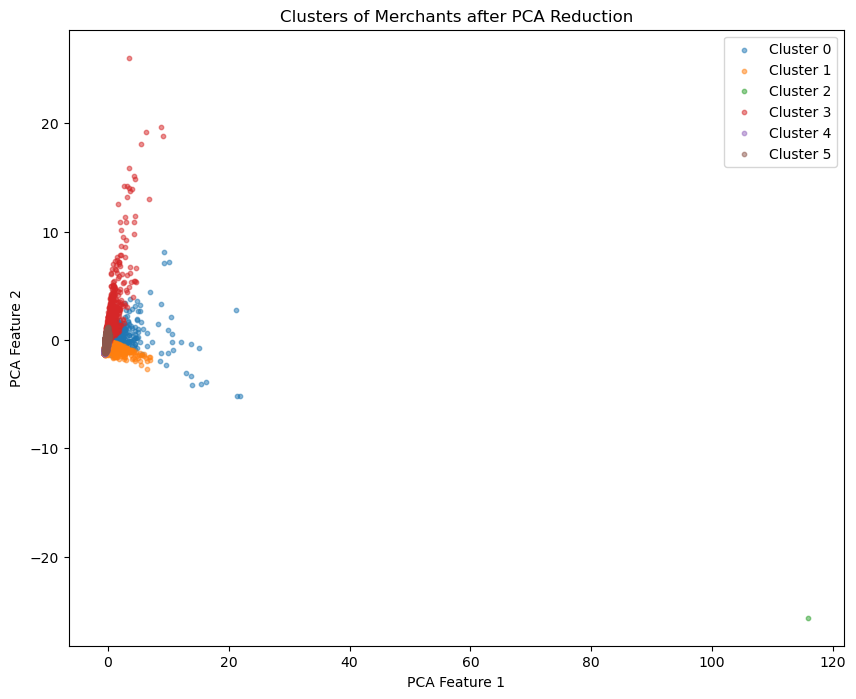

In [9]:
# Fit GMM with the optimal number of clusters
gmm = GaussianMixture(n_components=optimal_n, random_state=0).fit(features_scaled)

cluster_labels = gmm.predict(features_scaled)

# Dimensionality reduction to 2D for visualization
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features_scaled)

# Plotting
plt.figure(figsize=(10, 8))
for i in range(optimal_n):
    plt.scatter(features_pca[cluster_labels == i, 0], features_pca[cluster_labels == i, 1], label=f'Cluster {i}', s=10, alpha=0.5)

plt.title('Clusters of Merchants after PCA Reduction')
plt.xlabel('PCA Feature 1')
plt.ylabel('PCA Feature 2')
plt.legend()
plt.show()


In [10]:
## Due to outlier plot is highly compressed on the majority of point. We will try a few thing later.

In [11]:
# Assuming 'cluster_labels' contains the cluster assignments for each merchant

df1_grouped['cluster'] = cluster_labels
df1_grouped[['merchant','cluster']].head()

,merchant,cluster
0,00057d4302,4
1,000ed1585f,0
2,000f8c3297,5
3,0020aefbd9,1
4,0026f256ac,1


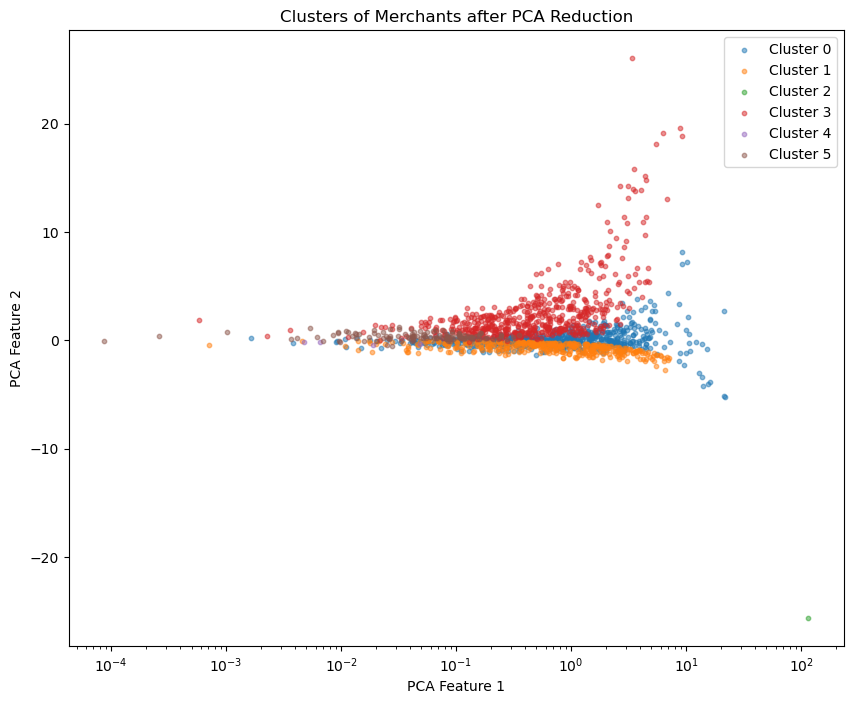

In [12]:
# To address the outlier, lets try some adjustments in the plot to improve Visuals.

# Plotting with logarithmic scal to better adjust for outliers

plt.figure(figsize=(10, 8))
for i in range(optimal_n):
    plt.scatter(features_pca[cluster_labels == i, 0], features_pca[cluster_labels == i, 1], 
                label=f'Cluster {i}', s=10, alpha=0.5)

plt.xscale('log')
plt.title('Clusters of Merchants after PCA Reduction')
plt.xlabel('PCA Feature 1')
plt.ylabel('PCA Feature 2')
plt.legend()
plt.show()


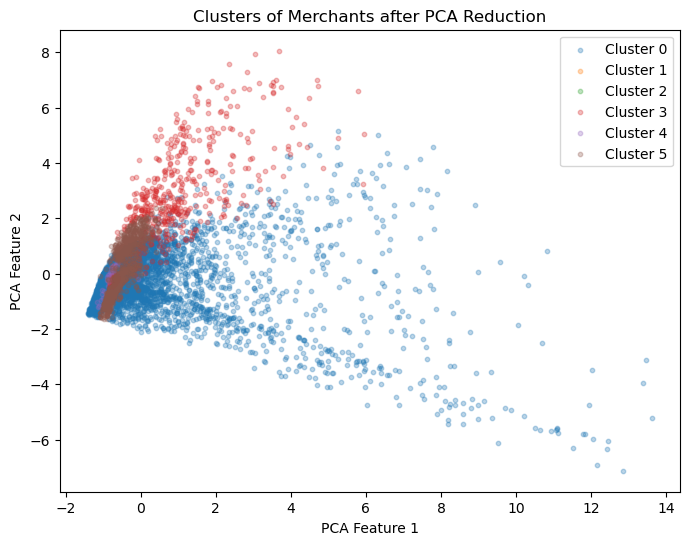

In [13]:
# We could remove all outliers for our analysis too
# To take a look at the plot and clusters in closer details

# Identify outliers in the original featurs. This is a simple method based on the Z-score. We will
# 3 standard deviations as an outlier
outliers = np.any(np.abs(features - features.mean()) > (3 * features.std()), axis=1)

# Remove outliers
features_no_outliers = features[~outliers]
features_no_outliers_scaled = StandardScaler().fit_transform(features_no_outliers)

# Fit GMM with the optimal number of clusters
gmm2 = GaussianMixture(n_components=optimal_n, random_state=0).fit(features_no_outliers_scaled)
cluster_labels2 = gmm.predict(features_no_outliers_scaled)

# Dimensionality reduction to 2D for visualization
pca2 = PCA(n_components=2)
features_pca2 = pca2.fit_transform(features_no_outliers_scaled)

# Plotting
plt.figure(figsize=(8, 6))
for i in range(optimal_n):
    plt.scatter(features_pca2[cluster_labels2 == i, 0], features_pca2[cluster_labels2 == i, 1], label=f'Cluster {i}',s=10, alpha=0.3)
plt.title('Clusters of Merchants after PCA Reduction')
plt.xlabel('PCA Feature 1')
plt.ylabel('PCA Feature 2')
plt.legend()
plt.show()


In [14]:
# We ended removing 469 outliers
outliers.sum()

469

In [15]:
# Let's go back to our dataset with all merchants included

In [16]:
# Count the number of merchants in each cluster
cluster_counts = df1_grouped['cluster'].value_counts()

# Sort the clusters by their labels for readability (optional)
cluster_counts = cluster_counts.sort_index()

# Display the counts
print(cluster_counts)


0     767
1    2639
2       1
3     641
4    1893
5    1961
Name: cluster, dtype: int64


In [18]:
features = ['trans_amount_min', 'trans_amount_max', 'trans_amount_avg', 'trans_amount_volume',
                        'trans_frequency','trans_recency','avg_time_btwn_trans','avg_trans_growth_rate']

# Ensure 'cluster' is included for grouping
features_with_cluster = features + ['cluster']

# Group df1_grouped by 'cluster', calculate mean for specified features, and count the number of merchants in each cluster
cluster_summary = df1_grouped.groupby('cluster')[features].agg(['mean'])
cluster_summary['merchant_count'] = df1_grouped.groupby('cluster')['merchant'].count()

# Flattening the column names 
cluster_summary.columns = ['_'.join(col).strip() for col in cluster_summary.columns.values]

# Rename the 'merchant_count_' column to 'merchant_count'
cluster_summary.rename(columns={'merchant_count_': 'merchant_count'}, inplace=True)

# Reset index 
cluster_summary.reset_index(inplace=True)

pd.options.display.float_format = '{:,.2f}'.format
cluster_summary


,cluster,trans_amount_min_mean,trans_amount_max_mean,trans_amount_avg_mean,trans_amount_volume_mean,trans_frequency_mean,trans_recency_mean,avg_time_btwn_trans_mean,avg_trans_growth_rate_mean,merchant_count
0,0,"59,516.50","265,544.50","126,366.85","584,249.23",5.84,137.70,"1,846.70",681.17,767
1,1,"32,387.75","32,387.75","32,387.75","32,387.75",1.00,238.33,0.00,0.00,2639
2,2,"10,385,508.00","10,385,508.00","10,385,508.00","10,385,508.00",1.00,76.00,0.00,0.00,1
3,3,"2,816.63","105,541.21","19,941.76","1,134,635.02",96.87,24.45,240.51,108.98,641
4,4,"5,070.99","10,205.29","7,503.50","20,151.52",2.93,192.22,"1,557.39",37.97,1893
5,5,"4,190.63","26,989.24","11,772.91","123,493.73",12.88,114.12,715.85,69.02,1961


In [19]:
# Exclude 'merchant_count' from ranking but include it in the final DataFrame
features_for_ranking = [col for col in cluster_summary.columns if col not in ['cluster', 'merchant_count']]

# Rank the clusters based on each feature, with 1 being the highest mean value
cluster_ranks = cluster_summary[features_for_ranking].rank(ascending=False)

cluster_ranks = cluster_ranks.astype(int)

# Including the 'cluster' column to identify each row and 'merchant_count' to show the size of each cluster
cluster_ranks['cluster'] = cluster_summary['cluster']
cluster_ranks['merchant_count'] = cluster_summary['merchant_count']

# Reordering columns to have 'cluster' and 'merchant_count' as the first columns for better readability
cols = ['cluster', 'merchant_count'] + [col for col in cluster_ranks.columns if col not in ['cluster', 'merchant_count']]
cluster_ranks = cluster_ranks[cols]

cluster_ranks


,cluster,merchant_count,trans_amount_min_mean,trans_amount_max_mean,trans_amount_avg_mean,trans_amount_volume_mean,trans_frequency_mean,trans_recency_mean,avg_time_btwn_trans_mean,avg_trans_growth_rate_mean
0,0,767,2,2,2,3,3,3,1,1
1,1,2639,3,4,3,5,5,1,5,5
2,2,1,1,1,1,1,5,5,5,5
3,3,641,6,3,4,2,1,6,4,2
4,4,1893,4,6,6,6,4,2,2,4
5,5,1961,5,5,5,4,2,4,3,3


In [20]:
# Using both tables we can see some charactheristics of the clusters

### Cluster 0 has few merchants which transact with high volumne and high average transaction value
### Cluster 2 has one very outlier merchannt with only very large transaction
### Cluster 1, has many merchants with only transaction
### Cluster 4 and 5 have low average transaction mean

## Task 3:Churn Prediction

In [21]:
df1_grouped.head()

,merchant,trans_amount_min,trans_amount_max,trans_amount_avg,trans_amount_volume,trans_frequency,trans_recency,avg_time_btwn_trans,avg_trans_growth_rate,cluster
0,00057d4302,1156,1279,"1,217.50",2435,2,580,1.43,10.64,4
1,000ed1585f,21932,35784,"28,050.25",112201,4,174,"3,424.03",-8.13,0
2,000f8c3297,3455,15047,"6,635.56",106169,16,58,508.47,22.68,5
3,0020aefbd9,3589,3589,"3,589.00",3589,1,215,0.00,0.00,1
4,0026f256ac,34880,34880,"34,880.00",34880,1,472,0.00,0.00,1


In [22]:
churned_merchants = df1_grouped[df1_grouped['trans_recency'] >= 30]['merchant'].count()
print("Number of merchants with no transaction in 30 day or more: ", churned_merchants)

Number of merchants with no transaction in 30 day or more:  5679


In [23]:
active_merchants = df1_grouped[df1_grouped['trans_recency'] < 30]['merchant'].count()
print("Number of merchants with transactions with the last 30 days: ", active_merchants)

Number of merchants with transactions with the last 30 days:  2223


In [24]:
# Add 'churn' column based on 'trans_recency'
df1_grouped['churn'] = np.where(df1_grouped['trans_recency'] >= 30, 1, 0)


In [25]:
df1_grouped.groupby('churn')['merchant'].count()

churn
0    2223
1    5679
Name: merchant, dtype: int64

In [26]:
X = df1_grouped.drop(columns=['merchant', 'churn','trans_recency']) #we need to drop all these columns 
y = df1_grouped['churn']

# scale features 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [28]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

# Define the parameter grid to search over
param_grid = {
    'max_depth': [3, 5,10,20],
    'learning_rate': [0.001, 0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 500, 1000]
}

# Initialize the classifier
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Setup GridSearchCV
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=5, scoring='accuracy',n_jobs=-1, verbose=2)

# Perform grid search
grid_search.fit(X_train, y_train)

# Get the best estimator
best_xgb = grid_search.best_estimator_


Fitting 5 folds for each of 64 candidates, totalling 320 fits


In [29]:
best_xgb

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [30]:
# Best parameters and best score
print("Best score in training: %0.3f" % grid_search.best_score_)
print("Best parameters set:")

best_parameters = grid_search.best_estimator_.get_params()

for param_name in sorted(param_grid.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

y_pred = grid_search.predict(X_test)

print(classification_report(y_test, y_pred))


Best score in training: 0.776
Best parameters set:
	learning_rate: 0.01
	max_depth: 3
	n_estimators: 200
              precision    recall  f1-score   support

           0       0.74      0.40      0.52       421
           1       0.81      0.95      0.88      1160

    accuracy                           0.80      1581
   macro avg       0.78      0.67      0.70      1581
weighted avg       0.79      0.80      0.78      1581



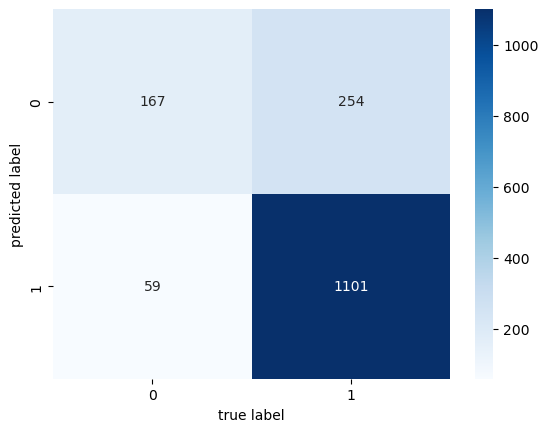

In [31]:
mat = confusion_matrix(y_test, y_pred)
labels = np.unique(y_test)

sns.heatmap(mat, annot=True, fmt='g', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('true label')
plt.ylabel('predicted label');

    
plt.show()

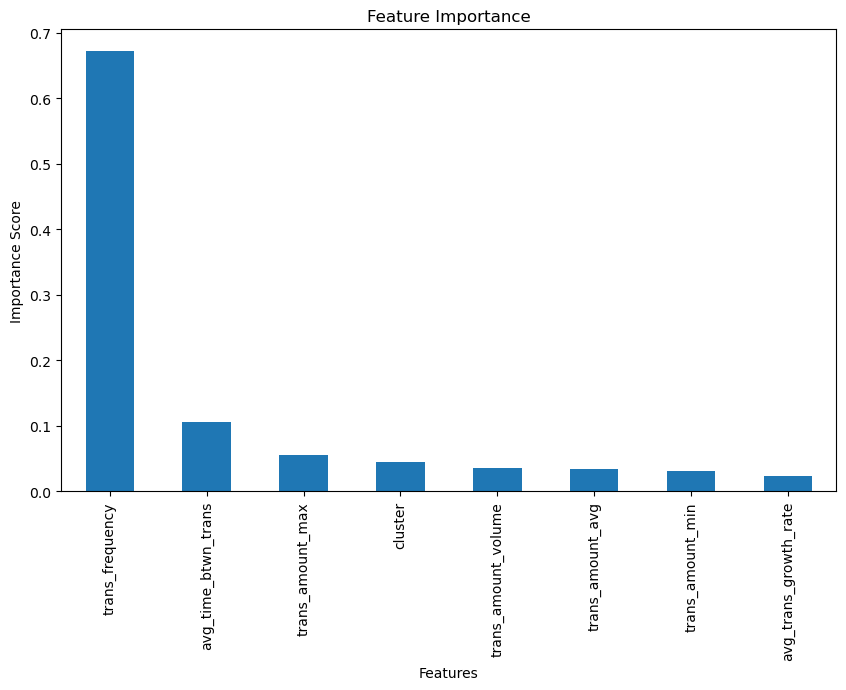

In [32]:
feature_importances = best_xgb.feature_importances_
feature_names = X.columns

# Create a pandas series to hold the feature importances and names
importances = pd.Series(feature_importances, index=feature_names)

# Sort the feature importances in descending order
importances_sorted = importances.sort_values(ascending=False)

# Plot
plt.figure(figsize=(10, 6))
importances_sorted.plot(kind='bar')
plt.title('Feature Importance')
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.show()


In [33]:
## We will test if using SMOTE for the unbalanced dataset helps improving metrics

In [34]:
param_grid = {
    'xgb__max_depth': [3, 5,10,20],
    'xgb__learning_rate': [0.001, 0.01, 0.1, 0.2],
    'xgb__n_estimators': [100, 200, 500, 1000]
}

# Define the pipeline
pipeline = IMBPipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='logloss'))
])


In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Setup GridSearchCV
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)

# Perform grid search
grid_search.fit(X_train, y_train)

# Get the best estimator
best_pipeline = grid_search.best_estimator_


Fitting 5 folds for each of 64 candidates, totalling 320 fits


In [36]:
y_pred = best_pipeline.predict(X_test)

# Evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')


Accuracy: 0.7609108159392789
Precision: 0.8509874326750448
Recall: 0.8172413793103448
F1 Score: 0.83377308707124


In [37]:
### Adding SMOTE improve PRECISION, but in general deteriorated somewhat Accurracy, Recall and F1

# Question 2: Unsupervised Learning on Property Dataset with PCA and Clustering Techniques

In [38]:
df2 = pd.read_csv('homework7_file2.csv')
df2.head()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,12833975,NaN,NaN,NaN,3.00,4.00,NaN,6.00,3.00,NaN,...,NaN,NaN,"155,403.00","304,592.00","2,016.00","149,189.00","3,708.29",NaN,NaN,"60,374,100,000,000.00"
1,11070096,1.00,NaN,NaN,4.00,4.00,NaN,7.00,4.00,NaN,...,NaN,NaN,"493,070.00","821,783.00","2,016.00","328,713.00","10,087.59",NaN,NaN,"60,371,100,000,000.00"
2,12752672,1.00,NaN,NaN,2.00,3.00,NaN,6.00,2.00,NaN,...,NaN,NaN,"126,695.00","247,962.00","2,016.00","121,267.00","3,377.86",NaN,NaN,"60,375,000,000,000.00"
3,11338563,NaN,NaN,NaN,3.00,4.00,NaN,7.00,3.00,NaN,...,NaN,NaN,"130,500.00","308,900.00","2,016.00","178,400.00","3,578.92",NaN,NaN,"60,379,200,000,000.00"
4,17098704,NaN,NaN,NaN,0.00,3.00,NaN,NaN,NaN,NaN,...,1.00,NaN,"142,271.00","223,101.00","2,016.00","80,830.00","2,564.86",NaN,NaN,"61,110,000,000,000.00"


In [39]:
df2.isna().sum()

parcelid                           0
airconditioningtypeid           7219
architecturalstyletypeid        9987
basementsqft                    9996
bathroomcnt                       13
bedroomcnt                        13
buildingclasstypeid             9961
buildingqualitytypeid           3530
calculatedbathnbr                388
decktypeid                      9932
finishedfloor1squarefeet        9305
calculatedfinishedsquarefeet     149
finishedsquarefeet12             859
finishedsquarefeet13            9974
finishedsquarefeet15            9388
finishedsquarefeet50            9305
finishedsquarefeet6             9928
fips                              13
fireplacecnt                    8953
fullbathcnt                      388
garagecarcnt                    6978
garagetotalsqft                 6978
hashottuborspa                  9827
heatingorsystemtypeid           3757
latitude                          13
longitude                         13
lotsizesquarefeet                925
p

In [58]:
df2.groupby('roomcnt')['roomcnt'].count()

roomcnt
0.00     7704
1.51       13
2.00        2
3.00       21
4.00      140
5.00      326
6.00      624
7.00      536
8.00      429
9.00      141
10.00      48
11.00      12
12.00       2
13.00       1
14.00       1
Name: roomcnt, dtype: int64

### Data cleaning and imputation

In [40]:
# Columns to delete
cols_to_delete =['parcelid','architecturalstyletypeid','buildingclasstypeid'] # We don't need this mostly empty cols

# Columns to change to False
cols_to_false = ['hashottuborspa','fireplaceflag']

# Columns to change to N
cols_to_N = ['taxdelinquencyflag']

# Columns where NA values should be replaced with 0
cols_to_zero = ['airconditioningtypeid','basementsqft','fireplacecnt','garagetotalsqft','poolcnt',
                 'poolsizesum','pooltypeid10','pooltypeid2','pooltypeid7','storytypeid','threequarterbathnbr',
                 'typeconstructiontypeid','taxdelinquencyyear'] 

#Delete columns
df2 = df2.drop(columns=cols_to_delete, axis=1)

# Replace NA values with 0 in specified columns
df2[cols_to_zero] = df2[cols_to_zero].fillna(0)

# Replace NA with False
df2[cols_to_false] = df2[cols_to_false].fillna(False)

# Replace NA with N
df2[cols_to_N] = df2[cols_to_N].fillna('N')


# Identify CATEGORICAL variables
cat_cols = ['airconditioningtypeid', 'decktypeid','hashottuborspa','heatingorsystemtypeid',
           'propertylandusetypeid','storytypeid','typeconstructiontypeid','fireplaceflag','taxdelinquencyflag']  

# Convert each column in column_names to categorical
for column in cat_cols:
    df2[column] = df2[column].astype('category')

# For the rest of the columns, replace NA with median or most frequent value
for col in df2.columns:
    if df2[col].dtype == 'float64' or df2[col].dtype == 'int64':
        # Replace NA with mean for numerical columns
        df2[col] = df2[col].fillna(df2[col].mean())
    else:
        # Replace NA with the most frequent value (mode) for categorical columns
        # Ensure we select the first mode value in case there are multiple modes
        df2[col] = df2[col].fillna(df2[col].mode()[0])


### PCA 

In [41]:
# Identify categorical variables
categorical_cols = df2.select_dtypes(include=['object', 'category']).columns

# Identify numerical variables
numerical_cols = df2.select_dtypes(include=['int64', 'float64']).columns

# Create a transformer for numerical variables 
numerical_transformer = StandardScaler()

# Create a transformer for categorical variables (one-hot encoding)
categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse=False)

# Combine transformers into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Define the PCA model
pca = PCA(n_components=50) 

# Create a pipeline that first preprocesses the data then applies PCA
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('pca', pca)])

# Fit and transform the data
df_transformed = pipeline.fit_transform(df2)

df_pca = pd.DataFrame(df_transformed)



C:\Users\jrfal\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [42]:
# Let's take a look at our dataset after PCA (Columns Names are Principal Components, 0 is PC1, 1 is PC2 etc)
df_pca

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,-0.27,1.50,-0.37,0.60,-1.18,0.45,0.10,0.44,-0.25,-0.38,...,-0.06,0.07,0.06,0.01,0.06,0.02,-0.01,-0.02,0.02,0.03
1,3.03,2.76,0.63,-1.00,-1.34,0.82,1.76,0.36,-0.15,-0.08,...,-0.15,0.07,1.03,-0.28,-0.16,0.04,-0.16,-0.08,-0.06,0.07
2,-1.28,1.09,-0.37,0.44,-0.29,-0.02,0.41,0.37,0.21,0.08,...,0.04,0.04,0.00,0.04,0.00,-0.07,0.07,0.00,0.03,-0.01
3,0.44,1.98,2.10,-1.26,-1.54,-0.31,2.95,0.18,0.15,1.56,...,-0.13,-0.03,0.11,0.11,0.19,-0.03,-0.07,0.04,-0.09,0.05
4,0.08,-4.83,1.96,-3.29,0.18,1.81,0.27,0.28,1.15,-1.21,...,-0.64,-0.10,-0.28,0.20,0.14,-0.04,-0.02,-0.10,0.76,0.41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2.00,2.54,2.82,-1.14,-0.85,-1.71,-0.34,0.01,0.43,-0.07,...,-0.28,0.29,-0.03,-0.03,-0.00,-0.06,0.03,0.09,-0.12,-0.09
9996,-3.37,-0.03,-0.69,0.39,1.02,-0.23,0.51,-0.56,-0.31,0.21,...,0.19,-0.22,0.19,0.20,0.63,-0.17,0.51,-0.17,-0.04,-0.39
9997,-1.07,0.92,-0.81,-0.11,0.72,-0.16,1.09,-0.71,-0.46,-0.37,...,0.21,-0.14,0.24,0.25,0.66,-0.12,0.50,-0.17,-0.02,-0.37
9998,-1.05,1.42,2.38,-0.92,0.20,-2.69,-0.30,-0.45,0.27,0.45,...,-0.30,0.16,-0.05,-0.15,-0.19,0.04,-0.12,0.06,0.11,-0.34


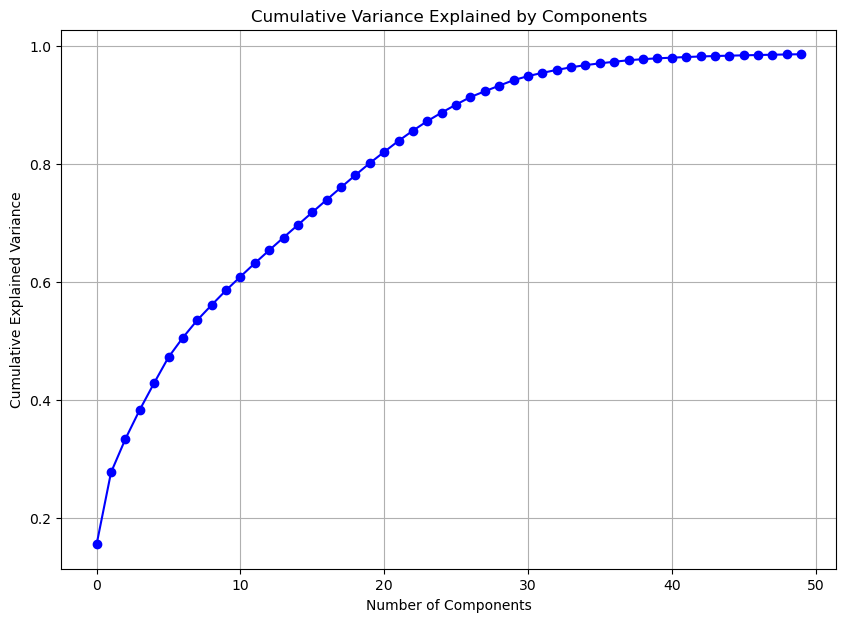

In [43]:
# Let's calculate variance captured by the Principal Components
model = pipeline.named_steps['pca']

# Get the explained variance ratio for each component
explained_variance_ratio = model.explained_variance_ratio_

# Calculate the cumulative sum of explained variances
cumulative_variance = np.cumsum(explained_variance_ratio)

# Plot the cumulative variance
plt.figure(figsize=(10, 7))
plt.plot(cumulative_variance, marker='o', linestyle='-', color='b')
plt.title('Cumulative Variance Explained by Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()


In [44]:
### We see that curves flatten at around 40 Components.

### Clustering

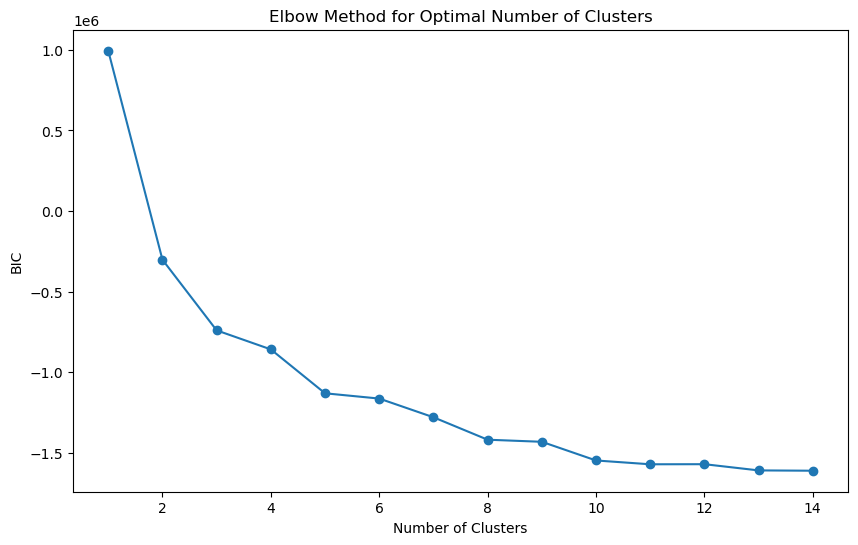

In [45]:
X = df_transformed[:,0:40]  # Just the first 40 colummns since that was our number of components to keep  

# Define the range of clusters to try
n_clusters = range(1, 15)

bics = []

for n in n_clusters:
    gmm = GaussianMixture(n_components=n, random_state=0).fit(X)
    bics.append(gmm.bic(X))

plt.figure(figsize=(10, 6))
plt.plot(n_clusters, bics, marker='o')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('BIC')
plt.show()


In [46]:
### We see the elbow at around 5 clusters

In [47]:
optimal_n_clusters = 5

# Fit the GMM
gmm = GaussianMixture(n_components=optimal_n_clusters, random_state=42).fit(X)

# Predict the cluster for each sample
cluster_labels = gmm.predict(X)


In [48]:
df2['Cluster_Label'] = cluster_labels

In [49]:
df2.head()

,airconditioningtypeid,basementsqft,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,...,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,Cluster_Label
0,0.00,0.00,3.00,4.00,6.00,3.00,66.00,"1,392.47","1,812.00","1,812.00",...,False,"155,403.00","304,592.00","2,016.00","149,189.00","3,708.29",N,0.00,"60,374,100,000,000.00",1
1,1.00,0.00,4.00,4.00,7.00,4.00,66.00,"1,392.47","3,134.00","3,134.00",...,False,"493,070.00","821,783.00","2,016.00","328,713.00","10,087.59",N,0.00,"60,371,100,000,000.00",0
2,1.00,0.00,2.00,3.00,6.00,2.00,66.00,"1,392.47","1,817.00","1,817.00",...,False,"126,695.00","247,962.00","2,016.00","121,267.00","3,377.86",N,0.00,"60,375,000,000,000.00",1
3,0.00,0.00,3.00,4.00,7.00,3.00,66.00,"1,392.47","2,280.00","2,280.00",...,False,"130,500.00","308,900.00","2,016.00","178,400.00","3,578.92",N,0.00,"60,379,200,000,000.00",0
4,0.00,0.00,0.00,3.00,6.31,2.31,66.00,"1,200.00","1,200.00","1,200.00",...,False,"142,271.00","223,101.00","2,016.00","80,830.00","2,564.86",N,0.00,"61,110,000,000,000.00",2


In [50]:
# Lets count by cluster
df2.groupby('Cluster_Label')['Cluster_Label'].count()

Cluster_Label
0    2008
1    4562
2     756
3     248
4    2426
Name: Cluster_Label, dtype: int64

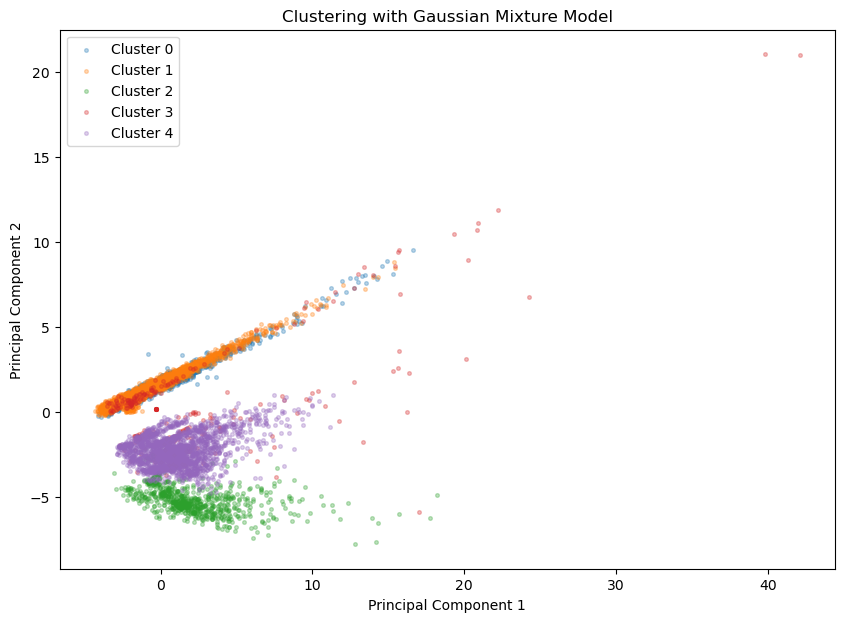

In [51]:
# Let's plot the clusters in 2D
plt.figure(figsize=(10, 7))

for cluster in np.unique(cluster_labels):
    plt.scatter(X[cluster_labels == cluster, 0], X[cluster_labels == cluster, 1], label=f'Cluster {cluster}',
               s=7, alpha=0.3)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Clustering with Gaussian Mixture Model')
plt.legend()
plt.show()


In [57]:
# Compare clusters
features_to_include = ['yearbuilt','roomcnt','bathroomcnt','calculatedfinishedsquarefeet','regionidzip']

# Group by 'cluster_label' and calculate the mean for the specified features
cluster_means = df2.groupby('Cluster_Label')[features_to_include].mean()

# Calculate the size (count of items) for each cluster
cluster_sizes = df2.groupby('Cluster_Label').size().reset_index(name='count')

# Merge the mean values and sizes (counts) together based on the cluster label
cluster_summary = cluster_means.merge(cluster_sizes, on='Cluster_Label')

# Reset index if you want 'cluster_label' as a column in the final DataFrame
#cluster_summary.reset_index(inplace=True)


cluster_summary

,Cluster_Label,yearbuilt,roomcnt,bathroomcnt,calculatedfinishedsquarefeet,regionidzip,count
0,0,"1,969.14",0.00,2.65,"1,852.83","96,704.61",2008
1,1,"1,955.09",0.00,2.07,"1,714.58","96,329.63",4562
2,2,"1,975.79",6.12,2.19,"1,886.14","96,937.29",756
3,3,"1,971.04",1.00,1.93,"3,384.16","96,584.15",248
4,4,"1,974.30",4.23,2.21,"1,865.95","96,931.99",2426


In [59]:
# Cluster 0 are mostly built around 1969 with roomcnt =0,
# Cluster 1 are the oldest houses average built 1955, also with 0 roomcnt
# Cluster 2 are properties with high room cnt
# Cluster 3 are lower roomcnt but now 0, but wirth high Square Feet
# Cluster 4 are room cnt medium range at 4, but lower square feet

# In general we also see most cluster are differentiated in Zip code except Cluster 2 and 4, whose
# main differentiator is roomcnt